<h1>Gender Classification of Facial Images Using CNN</h1>

<h2>This Notebook Covers</h2>
<h3><ol><li><a href="#1">Exploratory Data Analysis &amp; Data Cleaning</a></li>
    <li><a href="#2">Data Visualization</a></li>
    <li><a href="#3">Image Augmentation</a></li>
    <li><a href="#4">Model Development</a></li>
    <li><a href="#5">Model Evaluation</a></li>
    <li><a href="#6">Error Analysis</a></li>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from  IPython.display import display
from tensorflow.random import set_seed
np.random.seed(11)
set_seed(11)
random.seed(11)
!PYTHONHASHSEED=0

In [2]:
df = pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")

<a id="1"></a><h2>Exploratory Data Analysis &amp; Data Cleaning</h2>

In [3]:
df.shape

(23705, 5)

In [4]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


<h3>As seen above in the column 'pixels', the pixel data is in the form of a string where each pixel is separated by space. The function below converts the string into pixel array one row at a time.

In [5]:
def img_arr(x):
    '''
    Function to convert pixel data (string) into array of pixels
    '''
    x=x.reset_index(drop=True)
    n = len(x) #number of rows
    for i in range(n):
        if i==0:
            arr = np.array(x[i].split()).astype(np.int16) #Initializing the array
        else:
            arr = np.append(arr,np.array(x[i].split()).astype(np.int16),axis=0) #Appending data to the array
    return arr.reshape(n,48,48,1) #reshaping the array to 4-dim image pixel array

In [6]:
#Splitting dataset into X and y
X = df.iloc[:,4].copy()
y = df.iloc[:,2].copy()

In [7]:
# As seen below the class is fairly balanced
y.value_counts()

0    12391
1    11314
Name: gender, dtype: int64

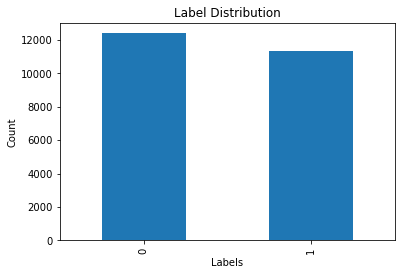

In [8]:
y.value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count");

In [9]:
#splitting the data into train and te sets. 'te' set will be further split into validation and test sets 
X_train,X_te,y_train,y_te = train_test_split(X,y,test_size=0.3,random_state=11)

In [10]:
#splitting 'te' set into validation and test set
X_val,X_test,y_val,y_test = train_test_split(X_te,y_te,test_size=0.15,random_state=11)

In [11]:
#Converting the string of pixels into image array for each of train, val and test set
X_train = img_arr(X_train)
X_test = img_arr(X_test)
X_val = img_arr(X_val)

In [12]:
y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

<a id="2"></a><h2>Data Visualization</h2>
<h3>The code below displays 100 random faces and their genders. This helps in identifying anomalies in labeling and also helps in framing rules for image augmentation.

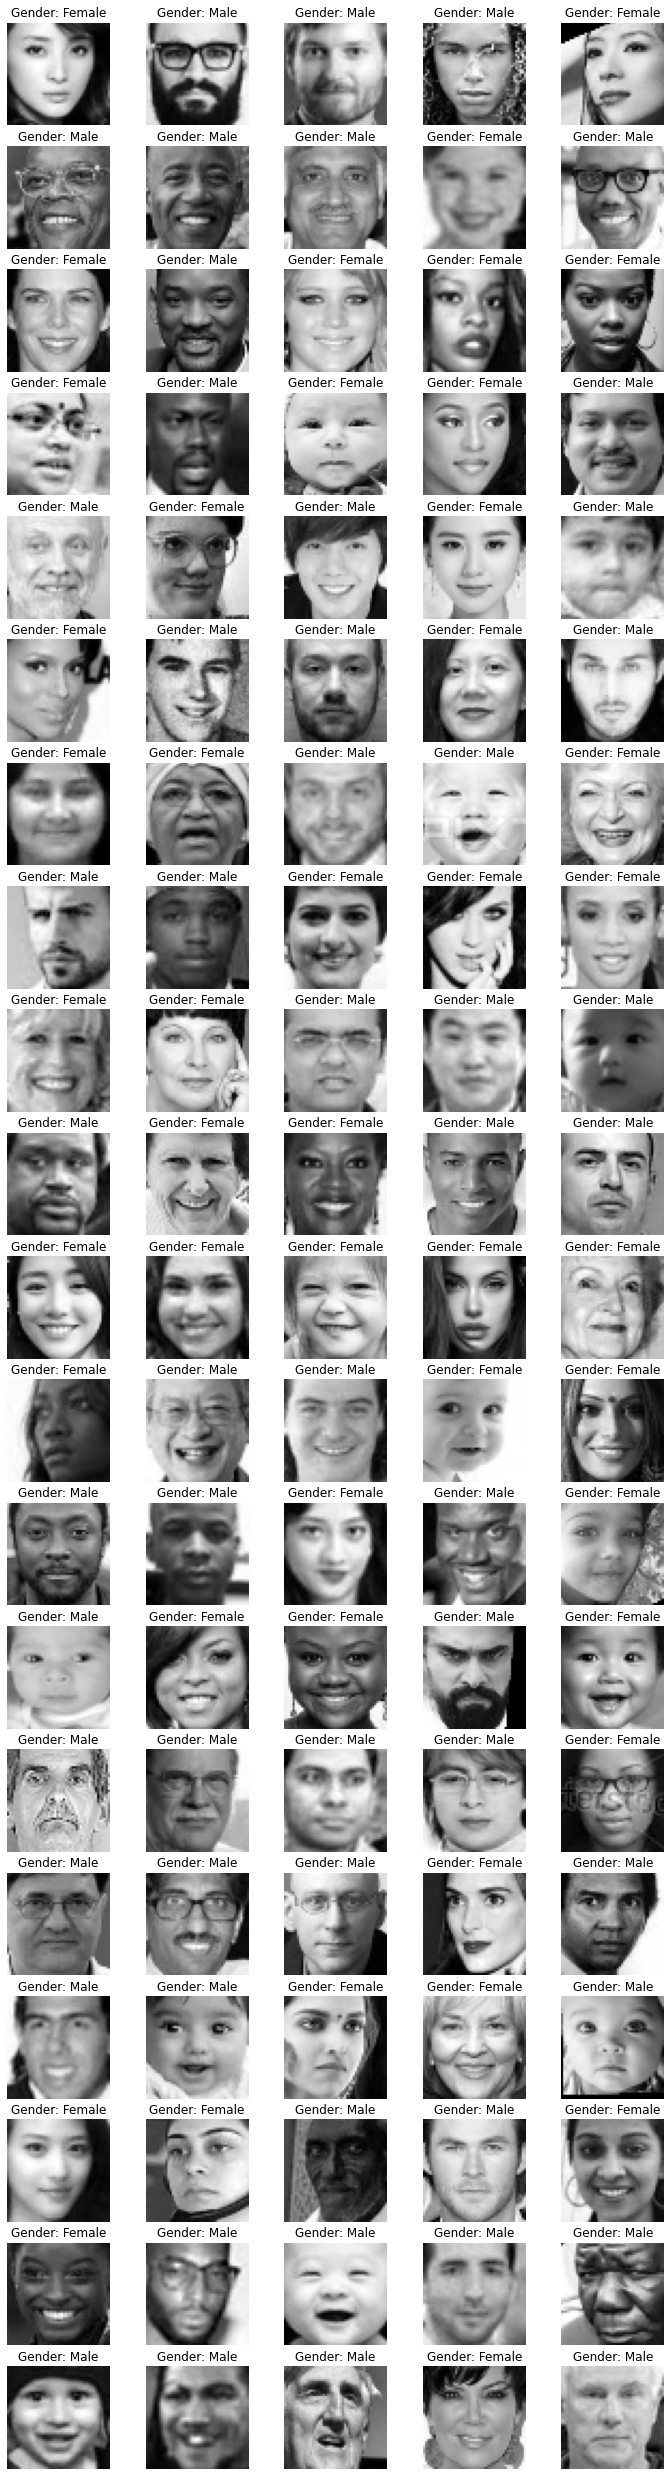

In [13]:
rows=20 #rows in subplots
cols=5 #columns in subplots
samp = random.sample(range(X_train.shape[0]),rows*cols) #selecting 100 random samples
x_samp = X_train[samp,:,:,:]
y_samp = y_train[samp]

fig,ax = plt.subplots(rows,cols,figsize=(12,45))
r = 0
c = 0
for i in range(rows*cols):
    aa = x_samp[i,:,:,:].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    ax[r,c].set_title(f"Gender: {'Female' if y_samp[i]==1 else 'Male'}")
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()

<h3>From the above data visualization, it is found that 0 indicates Male and 1 indicates Female. Also, there are a few images with wrong labels.

In [14]:
set_seed(11)
random.seed(11)
np.random.seed(11)

<a id="3"></a><h2>Image Augmentation</h2>
<h3>Image augmentation is a process of transorming images with a set of pre-specified rules. Image augmentation doesn't result in additional images, rather it randomly transforms the images in every epoch and inputs to the CNN. This enables the CNN to train on multiple tranforms of the original image and prevents overfitting.</h3>
<h3>We must transform the training images only, validation and test images must be left untouched, except for scaling

In [15]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                   width_shift_range=1,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8,1.2],
                                    rescale=1/255
                                   )


val_data_gen = ImageDataGenerator(rescale=1/255)

test_data_gen = ImageDataGenerator(rescale=1/255)

<h3>The plot below shows random images in their original and augmented form

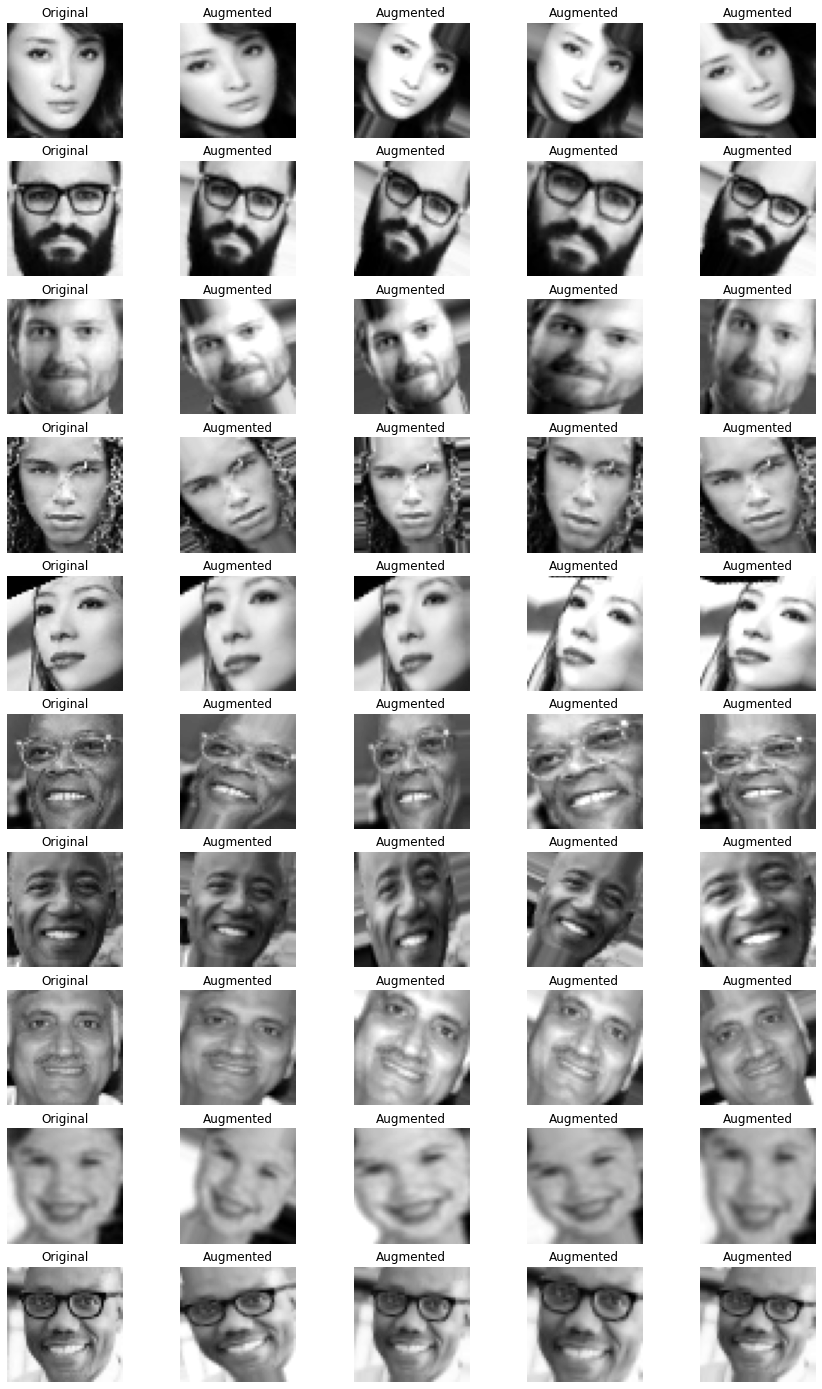

In [16]:
fig,ax = plt.subplots(10,5,figsize=(15,25))
for n in range(10):    
    r = random.sample(range(X_train.shape[0]),1)[0]
    ax[n,0].imshow(X_train[r].reshape(48,48),cmap="gray")
    ax[n,0].set_title("Original")
    ax[n,0].axis("off")
    for i in range(1,5):
        ax[n,i].imshow(train_data_gen.random_transform(X_train[r]).reshape(48,48),cmap="gray")
        ax[n,i].set_title("Augmented")
        ax[n,i].axis("off")
plt.show()

In [17]:
set_seed(11)
random.seed(11)
np.random.seed(11)
training_data = train_data_gen.flow(X_train,y_train,
                                   seed=11)

val_data = val_data_gen.flow(X_val,y_val,
                                   seed=11,shuffle=False)

test_data = test_data_gen.flow(X_test,y_test,
                                   seed=11,shuffle=False)

In [18]:
INPUT_SHAPE = (48,48,1)

<a id="4"></a><h2>Model Development</h2>
The CNN below is inspired by VGG16 and to match the current data the network architecture is modified accordingly

In [19]:
random.seed(11)
set_seed(11)
np.random.seed(11)
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu",input_shape=INPUT_SHAPE))
model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

model.add(Flatten())

model.add(Dense(units=512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["binary_accuracy"])

In [20]:
early_stop = EarlyStopping(monitor="val_loss",patience=5,mode="min") #Ensure the model doesn't overfit

In [21]:
random.seed(11)
set_seed(11)
np.random.seed(11)
history = model.fit(training_data,batch_size=32,epochs=500,callbacks=early_stop,validation_data=val_data)

Epoch 1/500
519/519 [==============================] - 14s 27ms/step - loss: 0.5825 - binary_accuracy: 0.6892 - val_loss: 0.5101 - val_binary_accuracy: 0.7706
Epoch 2/500
519/519 [==============================] - 15s 29ms/step - loss: 0.4772 - binary_accuracy: 0.7744 - val_loss: 0.3776 - val_binary_accuracy: 0.8318
Epoch 3/500
519/519 [==============================] - 13s 26ms/step - loss: 0.4291 - binary_accuracy: 0.7997 - val_loss: 0.3567 - val_binary_accuracy: 0.8467
Epoch 4/500
519/519 [==============================] - 13s 26ms/step - loss: 0.3967 - binary_accuracy: 0.8155 - val_loss: 0.3698 - val_binary_accuracy: 0.8263
Epoch 5/500
519/519 [==============================] - 14s 28ms/step - loss: 0.3726 - binary_accuracy: 0.8296 - val_loss: 0.3345 - val_binary_accuracy: 0.8518
Epoch 6/500
519/519 [==============================] - 14s 28ms/step - loss: 0.3556 - binary_accuracy: 0.8416 - val_loss: 0.3277 - val_binary_accuracy: 0.8528
Epoch 7/500
519/519 [=========================

In [22]:
#Dataframe capturing the accuracy and loss per epoch
loss_df = pd.DataFrame(history.history)
loss_df

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.582533,0.689206,0.510050,0.770554
1,0.477207,0.774363,0.377600,0.831762
2,0.429066,0.799675,0.356728,0.846650
3,0.396704,0.815525,0.369772,0.826303
4,0.372578,0.829567,0.334464,0.851778
5,0.355617,0.841620,0.327700,0.852771
6,0.343927,0.846622,0.289474,0.880728
7,0.333183,0.850720,0.307324,0.862862
8,0.320631,0.855963,0.303546,0.867328
9,0.319145,0.855361,0.284833,0.878908


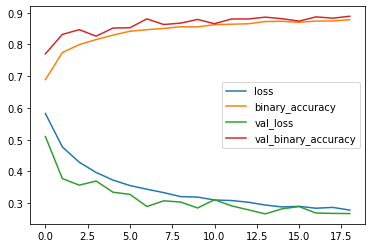

In [23]:
loss_df.plot();

<h3>Since, we got an idea on the optimum number of epochs to run from the above model training, now we'll concatenate the X_train, X_val and y_train, y_val to train the model on a larger dataset for a better performance. While training the model above I found 20 epochs as the optimum (might change due to randomness). Hence we'll train the final model for 20 epochs.

In [24]:
Final_train = np.append(X_train,X_val,axis=0)
Final_val = np.append(y_train,y_val,axis=0)

In [25]:
final_training_data = train_data_gen.flow(Final_train,Final_val,
                                   seed=11)

In [26]:
random.seed(11)
set_seed(11)
np.random.seed(11)
final_model_history = model.fit(final_training_data,batch_size=32,epochs=20)

Epoch 1/20
708/708 [==============================] - 18s 25ms/step - loss: 0.2875 - binary_accuracy: 0.8727
Epoch 2/20
708/708 [==============================] - 20s 29ms/step - loss: 0.2793 - binary_accuracy: 0.8788
Epoch 3/20
708/708 [==============================] - 18s 25ms/step - loss: 0.2799 - binary_accuracy: 0.8791
Epoch 4/20
708/708 [==============================] - 19s 27ms/step - loss: 0.2752 - binary_accuracy: 0.8778
Epoch 5/20
708/708 [==============================] - 18s 26ms/step - loss: 0.2753 - binary_accuracy: 0.8793
Epoch 6/20
708/708 [==============================] - 19s 27ms/step - loss: 0.2696 - binary_accuracy: 0.8855
Epoch 7/20
708/708 [==============================] - 18s 25ms/step - loss: 0.2658 - binary_accuracy: 0.8847
Epoch 8/20
708/708 [==============================] - 20s 29ms/step - loss: 0.2651 - binary_accuracy: 0.8847
Epoch 9/20
708/708 [==============================] - 20s 28ms/step - loss: 0.2658 - binary_accuracy: 0.8831
Epoch 10/20
708/708

<a id="5"></a><h2>Model Evaluation

In [27]:
model.evaluate(test_data)

34/34 [==============================] - 0s 4ms/step - loss: 0.2224 - binary_accuracy: 0.9063


[0.22238610684871674, 0.9062792658805847]

In [28]:
prediction = model.predict(test_data).flatten()

In [29]:
print(prediction)

[1.4162321e-04 9.4983321e-01 9.2407423e-01 ... 2.3243179e-05 7.8548783e-01
 3.0901535e-09]


In [30]:
prediction = np.round(prediction) #rounding so that the prediction >0.5 becones 1 and everything else becomes 0

In [31]:
prediction

array([0., 1., 1., ..., 0., 1., 0.], dtype=float32)

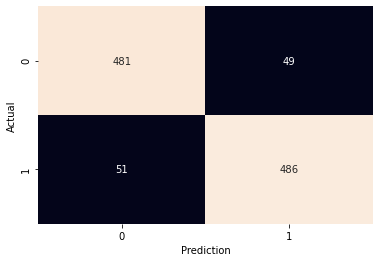

In [32]:
sns.heatmap(confusion_matrix(y_test,prediction),annot=True,cbar=False,fmt="d")
plt.xlabel("Prediction")
plt.ylabel("Actual");

In [33]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       530
           1       0.91      0.91      0.91       537

    accuracy                           0.91      1067
   macro avg       0.91      0.91      0.91      1067
weighted avg       0.91      0.91      0.91      1067



<a id="6"></a><h2>Error Analysis</h2>
<h3>Analyzing the errors visually may help in tuning image augmentation parameters as well as the model architecture. It also gives an idea of how the model may perform in the future and determine if the model matches human level performance.

In [34]:
error_index = (y_test != prediction)#finding error indices
y_test_error = y_test[error_index]
X_test_error = X_test[error_index]
prediction_error = prediction[error_index]

<h3>Below we visualize the errors and identify actual label vs predicted labels

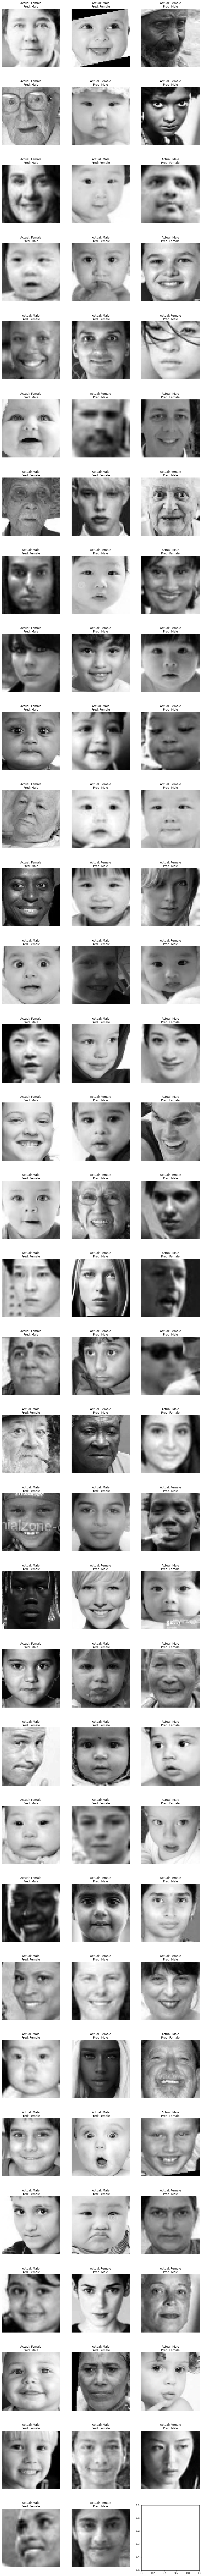

In [35]:
rows=int(np.floor(sum(error_index)/3)) #rows in subplots
cols=3 #columns in subplots
x_samp = X_test_error
y_samp = y_test_error

fig,ax = plt.subplots(rows,cols,figsize=(15,200))
r = 0
c = 0
for i in range((rows*cols)-1):
    aa = x_samp[i].reshape(48,48)
    ax[r,c].axis("off")
    ax[r,c].imshow(aa,cmap="gray")
    actual_lab = "Female" if y_samp[i]==1 else "Male"
    pred_lab = "Female" if int(prediction_error[i])==1 else "Male"
    ax[r,c].set_title(f'Actual: {actual_lab}\nPred: {pred_lab}')
    c+=1
    if c == cols:
        c=0
        r+=1
plt.show()

<h2>From the above error analysis, we can interpret that the model majorly misclassfied images of babies and kids (which even a human finds difficult to classify). This shows that beard and moustache and hair length might be the important features captured by the model for classifying the gender.